In [49]:
import plotly
import matplotlib.pyplot as plt
import plotly.express as px
import json
import numpy as np

In [50]:
V = lambda l,b,g,x: l*np.cos(x)-l+2*(sigma(l,b,g)-1)*np.log(1+np.cos(x))-2*sigma(l,b,g)*np.log(3-np.cos(x)+4*np.sin(x/2))
sigma = lambda l,b,g: b*g/np.sqrt(l)
PvvV0 = lambda l,b,g: l+1
PuuV0 = lambda l,b,g: 1-l
PuV0 = lambda l,b,g: -2*sigma(l,b,g)
PvvV1 = lambda l,b,g: l+np.sqrt(2)*sigma(l,b,g)+2
PuuV1 = lambda l,b,g: 1/np.cos(np.pi/5)**2+sigma(l,b,g)*np.tan(np.pi/5)*1/np.cos(np.pi/5)-l*np.cos(2*np.pi/5)
PuV1 = lambda l,b,g: -2*np.tan(np.pi/5)-2*sigma(l,b,g)*1/np.cos(np.pi/5)+l*np.sin(2*np.pi/5)
V0 = lambda l,b,g: -2 * np.log(2)
V1 = lambda l,b,g: V(l,b,g,-2*np.pi/5)

apex0 = lambda l,b,g: -PuV0(l,b,g)/PuuV0(l,b,g)
Vapex0 = lambda l,b,g: V0(l,b,g)-PuV0(l,b,g)**2/(2*PuuV0(l,b,g))
apex1 = lambda l,b,g: -PuV1(l,b,g)/PuuV1(l,b,g)-2*np.pi/5
Vapex1 = lambda l,b,g: V1(l,b,g)-PuV1(l,b,g)**2/(2*PuuV1(l,b,g))
k = lambda l,b,g: (Vapex0(l,b,g)-Vapex1(l,b,g))/(apex0(l,b,g)-apex1(l,b,g))

def analytic_time3(l,b,g):
    term1factor = g/k(l,b,g)*np.sqrt(PvvV0(l,b,g)/PvvV1(l,b,g))*(np.exp((Vapex0(l,b,g)-Vapex1(l,b,g))/g**2)-1)
    term1inner = np.sqrt(np.pi/(2*PuuV1(l,b,g)))+np.sqrt(-np.pi/(2*PuuV0(l,b,g)))+g/k(l,b,g)
    term2factor = np.sqrt(PvvV0(l,b,g)/PvvV1(l,b,g))
    term2inner = np.pi/(2*np.sqrt(-PuuV0(l,b,g)*PuuV1(l,b,g)))-1/k(l,b,g)*(apex0(l,b,g)-apex1(l,b,g))
    return term1factor*term1inner+term2factor*term2inner

In [51]:
with open('output3.json') as f:
    data = json.load(f)
with open('output4.json') as f:
    data2 = json.load(f)

In [52]:
def aggregate(data, keep_keys):
    agg = {}
    for data_ptr in data:
        key = tuple([data_ptr[key] for key in keep_keys])
        percent_err = data_ptr['log_err']
        if key not in agg:
            agg[key] = np.array([percent_err, 1])
        else:
            agg[key] += np.array([percent_err, 1])
    keys = list(agg.keys())
    vals = [agg[key][0]/agg[key][1] for key in keys]
    keys = [[key[i] for key in keys] for i in range(len(keep_keys))]
    return *keys, vals

In [ ]:
def process_data(data):
    for data_ptr in data:
        data_ptr['err_fit1'] = abs(np.log(data_ptr["sim_fit_time"]) -  np.log(data_ptr["sol1_time"])) / (data_ptr["sim_fit_time"]+1e-9) * 100
        data_ptr['err_fit3'] = abs(np.log(data_ptr["sim_fit_time"]) -  np.log(data_ptr["sol3_time"])) / (data_ptr["sim_fit_time"]+1e-9) * 100
        data_ptr['log_sim_fit_time'] = np.log(data_ptr["sim_fit_time"])
        data_ptr['log_sol1_time'] = np.log(data_ptr["sol1_time"])
        data_ptr['log_sol3_time'] = np.log(data_ptr["sol3_time"])
        data_ptr['log_err_fit1'] = abs((data_ptr['log_sim_fit_time'] - data_ptr['log_sol1_time']) / (data_ptr['log_sim_fit_time']+1e-9)) * 100
        data_ptr['log_err_fit3'] = abs((data_ptr['log_sim_fit_time'] - data_ptr['log_sol3_time']) / (data_ptr['log_sim_fit_time']+1e-9)) * 100
    return data
data = process_data(data)
data2 = process_data(data2)

AttributeError: 'list' object has no attribute 'keys'

In [ ]:
# for figure 2
import pandas as pd
df = pd.DataFrame(data)
df2 = pd.DataFrame(data2)

plt.rcParams.update({
    'lines.linewidth': 4,       # Line thickness
    'lines.markersize': 10,     # Marker size
    'axes.linewidth': 3,        # Border thickness for axes
    'axes.titlesize': 20,       # Title font size
    'axes.labelsize': 20,       # Label font size
    'xtick.labelsize': 20,      # X-axis tick label font size
    'ytick.labelsize': 20,      # Y-axis tick label font size
    'xtick.major.size': 10,     # Length of X-axis ticks
    'ytick.major.size': 10,     # Length of X-axis ticks
    'legend.fontsize': 20,      # Legend font size
    'legend.frameon': True,     # Enable legend frame
    'legend.framealpha': 0.9,   # Legend frame transparency
    'legend.edgecolor': 'black' # Legend frame border color
})
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

ax1.plot(df['b'], df['sim_fit_time'], 'o', markerfacecolor='blue', markeredgecolor='blue', label="g=0.4")
#plt.plot(df['b'], df['sol1_time'])
extended_b = list(np.linspace(-0.25, 0, 20))
extended_analytic = [analytic_time3(2,b,0.4) for b in extended_b]
ax1.plot(extended_b+list(df['b']), extended_analytic+list(df['sol3_time']), color='blue')
#ax1.plot(df['b'], df['sol1_time'], color='red')
ax1.set_title('λ=2, g=0.4', pad=20)
ax1.set_yscale('log')
ax1.set_ylabel('time')
ax1.set_xlabel('b')

ax2.plot(df2['b'], df2['sim_fit_time'], 'o', markerfacecolor='blue', markeredgecolor='blue', label="g=0.1")
#plt.plot(df['b'], df['sol1_time'])
extended_b = list(np.linspace(2.9, 3.15, 20))
extended_analytic = [analytic_time3(2,b,0.1) for b in extended_b]
ax2.plot(extended_b+list(df2['b']), extended_analytic+list(df2['sol3_time']), color='blue')
#ax2.plot(df2['b'], df2['sol1_time'], color='red')
ax2.legend(['Sim.', 'Th.'])
ax2.set_title('λ=2, g=0.1', pad=20)
ax2.set_yscale('log')
ax2.set_xlabel('b')

plt.tight_layout()
plt.savefig('time-vs-b-g04-l2.svg', format='svg',  bbox_inches='tight')
plt.show()

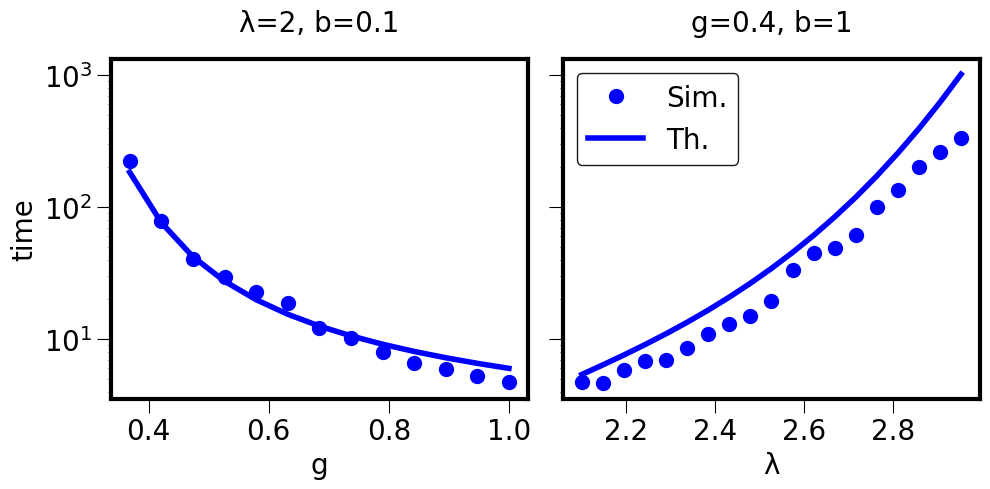

In [62]:
# for figure 3
df = pd.DataFrame(data)
df2 = pd.DataFrame(data2)

plt.rcParams.update({
    'lines.linewidth': 4,       # Line thickness
    'lines.markersize': 10,     # Marker size
    'axes.linewidth': 3,        # Border thickness for axes
    'axes.titlesize': 20,       # Title font size
    'axes.labelsize': 20,       # Label font size
    'xtick.labelsize': 20,      # X-axis tick label font size
    'ytick.labelsize': 20,      # Y-axis tick label font size
    'xtick.major.size': 10,     # Length of X-axis ticks
    'ytick.major.size': 10,     # Length of X-axis ticks
    'legend.fontsize': 20,      # Legend font size
    'legend.frameon': True,     # Enable legend frame
    'legend.framealpha': 0.9,   # Legend frame transparency
    'legend.edgecolor': 'black' # Legend frame border color
})
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5))

ax1.plot(df['g'], df['sim_fit_time'], 'o', markerfacecolor='blue', markeredgecolor='blue', label="b=0.1")
#plt.plot(df['b'], df['sol1_time'])
#extended_b = list(np.linspace(-0.25, 0, 20))
#extended_analytic = [analytic_time3(2,b,0.4) for b in extended_b]
ax1.plot(list(df['g']), list(df['sol3_time']), color='blue')
#ax1.plot(df['b'], df['sol1_time'], color='red')
ax1.set_title('λ=2, b=0.1', pad=20)
ax1.set_yscale('log')
ax1.set_ylabel('time')
ax1.set_xlabel('g')

ax2.plot(df2['lambda'], df2['sim_fit_time'], 'o', markerfacecolor='blue', markeredgecolor='blue', label="g=0.4")
#plt.plot(df['b'], df['sol1_time'])
#extended_b = list(np.linspace(2.9, 3.15, 20))
#extended_analytic = [analytic_time3(2,b,0.1) for b in extended_b]
ax2.plot(list(df2['lambda']), list(df2['sol3_time']), color='blue')
#ax2.plot(df2['lambda'], df2['sol1_time'], color='red')
ax2.legend(['Sim.', 'Th.'])
ax2.set_title('g=0.4, b=1', pad=20)
ax2.set_yscale('log')
ax2.set_xlabel('λ')

plt.tight_layout()
plt.savefig('time-vs-glambda.svg', format='svg',  bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
import plotly.graph_objects as go
df = pd.DataFrame(data)
fig = go.Figure(data=[
    #go.Scatter3d(x=df["g"], y=df["lambda"], z=df["log_sim_end_time"], mode="markers", marker=dict(size=3)),
    go.Scatter3d(x=df["g"], y=df["lambda"], z=df["log_sim_fit_time"], mode="markers", marker=dict(size=3)),
    go.Scatter3d(x=df["g"], y=df["lambda"], z=df["log_analytic_time"], mode="markers", marker=dict(size=3)),])
fig.show()


In [16]:
df = pd.DataFrame(data)
px.line(df, x="b", y="log_sol1_time")

In [79]:
fig = go.Figure(data=[
    go.Line(x=df["g"], y=df["log_sim_fit_time"],  marker=dict(size=3)),
    go.Line(x=df["g"], y=df["log_analytic_time"],  marker=dict(size=3)),])
fig.show()

/Users/yh_huang/venv/generic/lib/python3.9/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [57]:
gs, lambdas, errs = aggregate(data, ["g", "lambda"])
errs = [err if err<100 else 100 for err in errs]
plot_data = {"g": gs, "lambda": lambdas, "error": errs}
fig = px.scatter_3d(plot_data, x="g", y="lambda", z="error", color="error", title="Error vs g and lambda")
fig.update_traces(marker=dict(size=2))

In [58]:
bs, lambdas, errs = aggregate(data, ["b", "lambda"])
errs = [err if err<100 else 100 for err in errs]
plot_data = {"b": bs, "lambda": lambdas, "error": errs}
fig = px.scatter_3d(plot_data, x="b", y="lambda", z="error", color="error", title="Error vs b and lambda")
fig.update_traces(marker=dict(size=2))

In [59]:
gs, bs, errs = aggregate(data, ["g", "b"])
errs = [err if err<100 else 100 for err in errs]
plot_data = {"g": gs, "b": bs, "error": errs}
fig = px.scatter_3d(plot_data, x="g", y="b", z="error", color="error", title="Error vs g and b")
fig.update_traces(marker=dict(size=2))